In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12288)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
dataset_dir = '/content'
class_names = ['Benign', 'Pre', 'Pro', 'Early']

images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

In [4]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=None, stratify=labels)

In [ ]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'  
)

# test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
test_generator = test_datagen.flow(X_test, y_test, batch_size=128)

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer=Adam(learning_rate=1e-6),  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, epochs=25,  validation_data=test_generator,callbacks=[early_stopping])

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.2957 - loss: 2.6036 - val_accuracy: 0.3175 - val_loss: 1.6836
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 664ms/step - accuracy: 0.5070 - loss: 1.6124 - val_accuracy: 0.5031 - val_loss: 1.2213
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 639ms/step - accuracy: 0.6299 - loss: 1.0519 - val_accuracy: 0.6733 - val_loss: 0.8226
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 630ms/step - accuracy: 0.7171 - loss: 0.8086 - val_accuracy: 0.7929 - val_loss: 0.5607
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 640ms/step - accuracy: 0.7593 - loss: 0.6741 - val_accuracy: 0.8466 - val_loss: 0.3907
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 665ms/step - accuracy: 0.8261 - loss: 0.4958 - val_accuracy: 0.8850 - val_loss: 0.2918
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 634ms/step - accuracy: 0.8501 - loss: 0.4102 - val_accuracy: 0.9141 - val_loss: 0.2312
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 639ms/step - accuracy: 0.8814 - loss: 0.3431 - val_accuracy: 0.9356 

In [10]:
model.save("/content/Mymodel.h5")

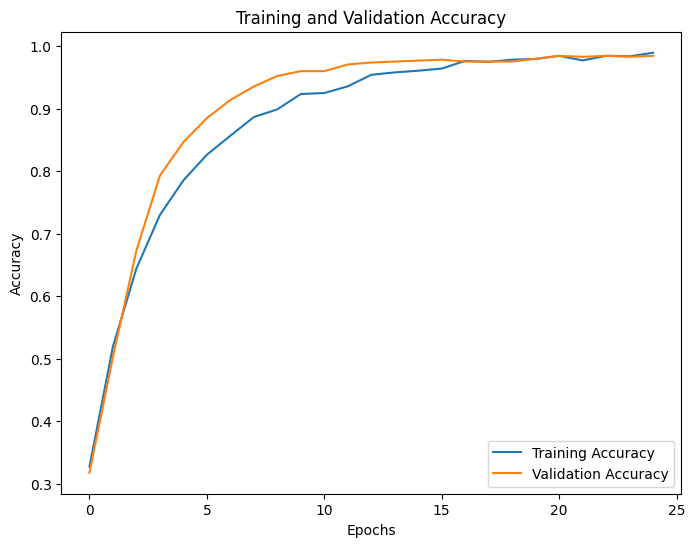

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

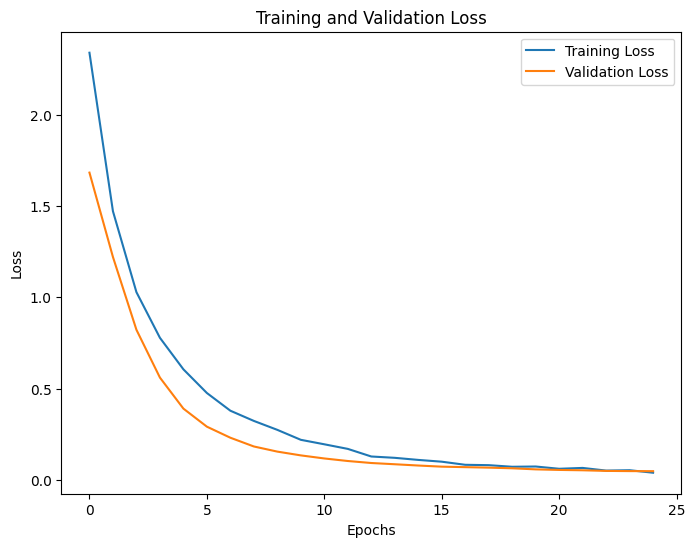

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
from tensorflow.keras.models import load_model

model = load_model('/content/Mymodel.h5')

In [15]:
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
f1 = f1_score(y_test, y_pred_classes, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')


print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


print(classification_report(y_test, y_pred_classes, target_names=class_names))

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step
Train Accuracy: 0.9896
Validation Accuracy: 0.9847
F1 Score: 0.9846
Cohen's Kappa: 0.9791
Recall: 0.9847
Precision: 0.9847
              precision    recall  f1-score   support

      Benign       0.98      0.95      0.96       101
         Pre       0.97      0.98      0.97       197
         Pro       0.99      0.99      0.99       193
       Early       1.00      1.00      1.00       161

    accuracy                           0.98       652
   macro avg       0.98      0.98      0.98       652
weighted avg       0.98      0.98      0.98       652



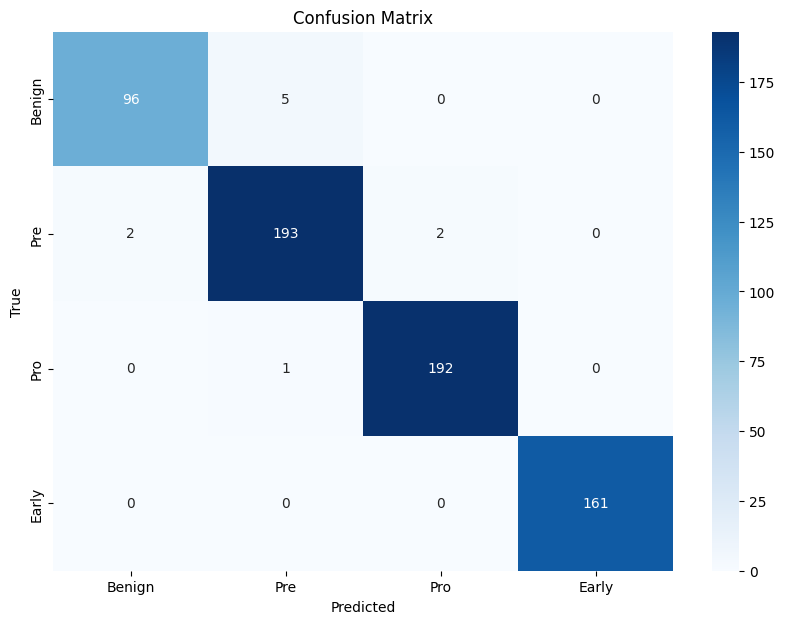

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


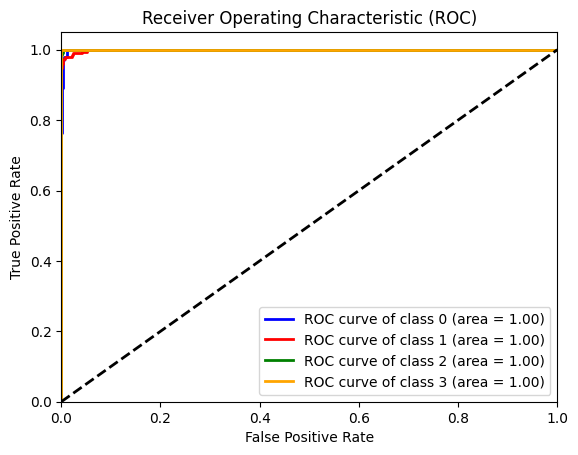

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2, 3])

y_prob = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()